This is an old tutorial from _Hands-On Machine Learning_ by Geron that I ran through a while ago to refresh my Python and familiarize myself with the libraries. I decided to make some edits and push it up to my github, since I don't have any significant public portfolio. This is about 80/20 the book's code vs my edits/additions. I tried to stick to the formula in the book, but there were spots where I couldn't help but depart - partly because I wanted to do some of my own exploration, and partly because I thought I could do some things more efficiently. For example, anything with _seaborn_ and _missingno_ are my additions.

Also see: There's an additional _housing.py_ file in this directory that contains a lot of extra stratch work for exploration and spot-checking of combined attributes. This contains a lot more of my own code - including some exploration of principle components.

In [1]:
## Library calls. I was always taught to do this all upfront, but apparently, that's not a thing anymore.
import os
import tarfile
from six.moves import urllib
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sb
%matplotlib inline


In [2]:
### Data Path "Constants"
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "../datasets/housing" # I moved this one folder up so I'm not storing unnecessary data on my github.
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

### Fetch Data from Online Source
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
### Read Data
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path,"housing.csv")
    try:
        csvReturn = pd.read_csv(csv_path)
    except:
        fetch_housing_data()
        csvReturn = pd.read_csv(csv_path)
    return csvReturn

In [4]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64


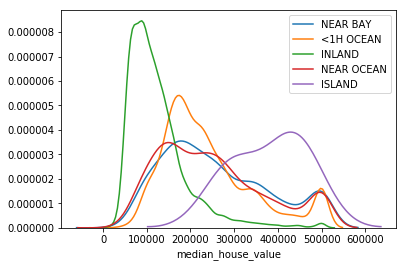

In [5]:
print(housing['ocean_proximity'].value_counts())
for op in housing["ocean_proximity"].unique():
    sb.distplot(housing["median_house_value"][housing["ocean_proximity"] == op], hist=False, label=op)
plt.legend();

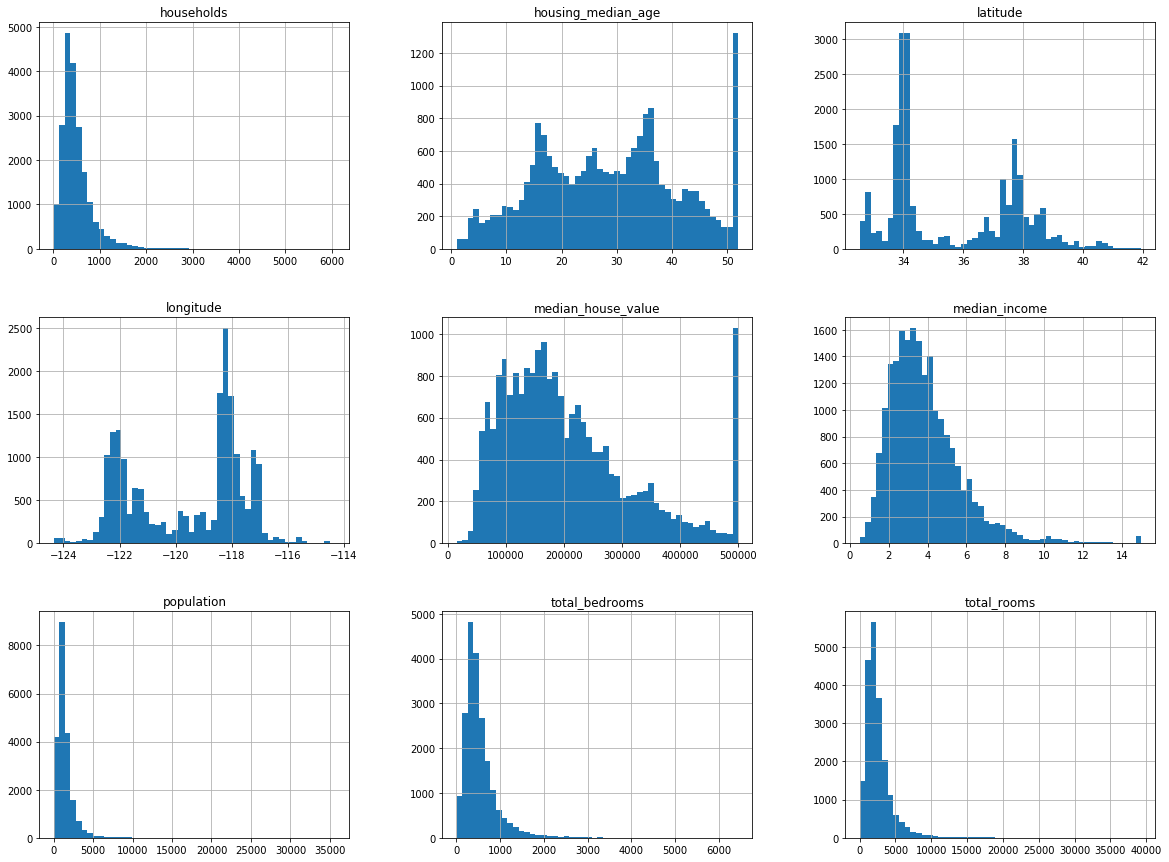

In [7]:
housing.hist(bins=50,figsize=(20,15))
plt.show()

In [8]:
## Basic training/test test set separation
from sklearn.model_selection import train_test_split

train, test = train_test_split(housing, test_size=0.2, random_state=42)
print( len(train), " train, ", len(test), " test.")

16512  train,  4128  test.


In [9]:
## Stratified training sample over income category
housing["income_cat"] = np.ceil(housing["median_income"]/1.5)
housing["income_cat"].where(housing["income_cat"] < 5 , 5.0 , inplace=True)

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train = housing.loc[train_index]
    strat_test = housing.loc[test_index]

print(housing["income_cat"].value_counts() / len(housing))

## Drop income category from resulting sets
for set in (strat_train, strat_test):
    set.drop(["income_cat"], axis=1, inplace=True)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64


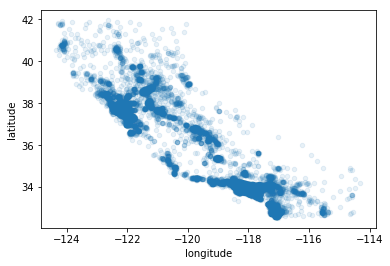

In [10]:
## Density of data points over geographic location
strat_train.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)


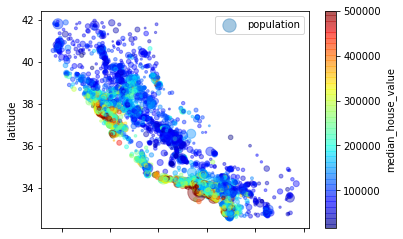

In [11]:
## Visualizing house value by geography
strat_train.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
                s=housing["population"]/100, label="population",
                c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64


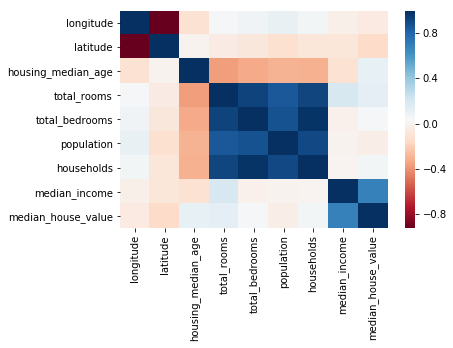

In [12]:
## Corrplot for numeric variables to assess base colinearity and identify possible predictors
corr_matrix = strat_train.corr()
print(corr_matrix["median_house_value"].sort_values(ascending=False))

sb.heatmap(corr_matrix, cmap="RdBu")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f36bb39df60>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f36bb4e1be0>]], dtype=object)

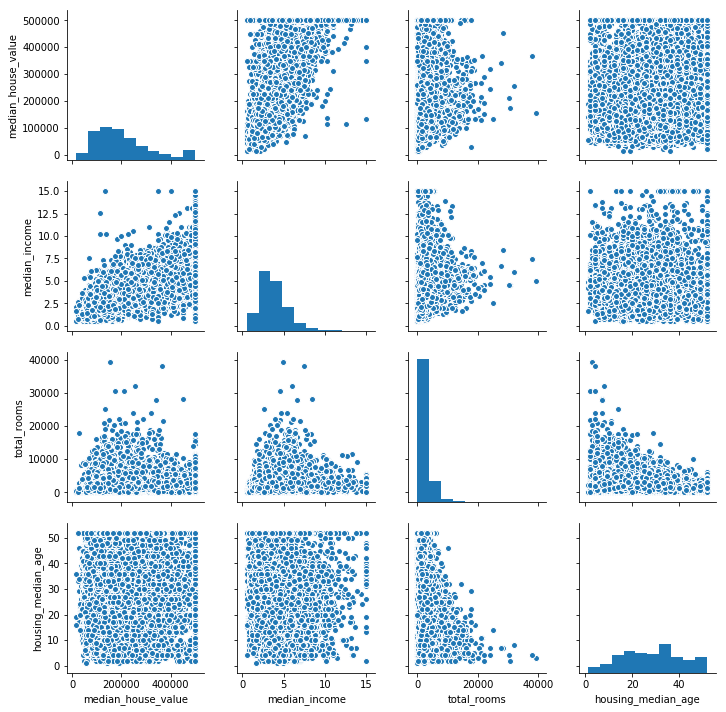

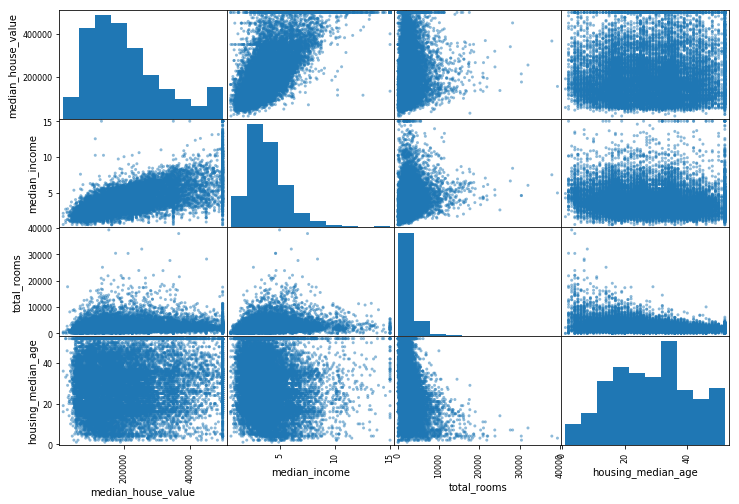

In [13]:
## Pairs plots
## I wanted to compare the seaborn pairs to pandas spm, so I ran both
sb.pairplot(strat_train, vars=["median_house_value","median_income","total_rooms","housing_median_age"])

from pandas.plotting import scatter_matrix

attr = ["median_house_value","median_income","total_rooms","housing_median_age"]
scatter_matrix(strat_train[attr], figsize=(12,8))

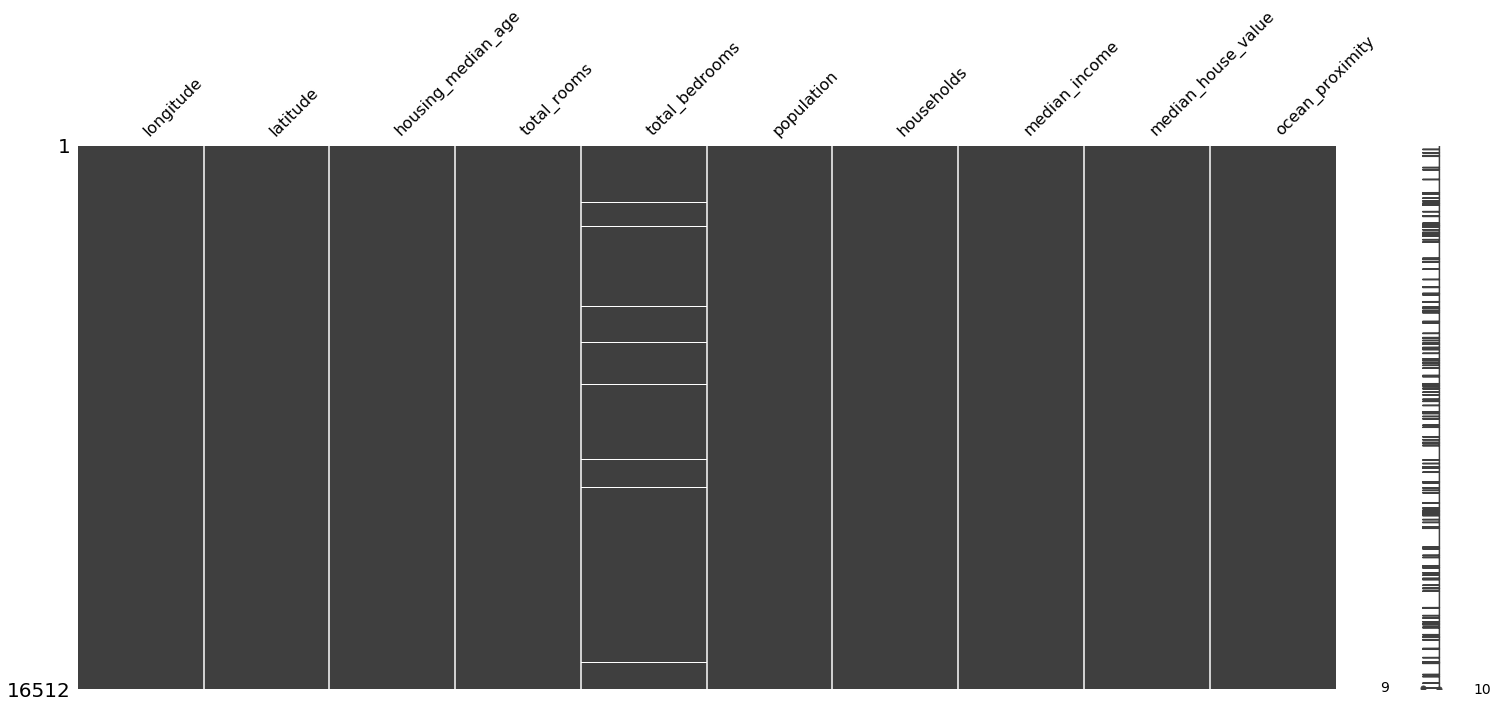

In [14]:
## Visualize missing values
import missingno as mn

mn.matrix(strat_train)

In [15]:
## List percentage of missing values by column
for s in list(strat_train):
    print(s,' ',sum(strat_train[s].isnull())/len(strat_train))

longitude   0.0
latitude   0.0
housing_median_age   0.0
total_rooms   0.0
total_bedrooms   0.009568798449612403
population   0.0
households   0.0
median_income   0.0
median_house_value   0.0
ocean_proximity   0.0


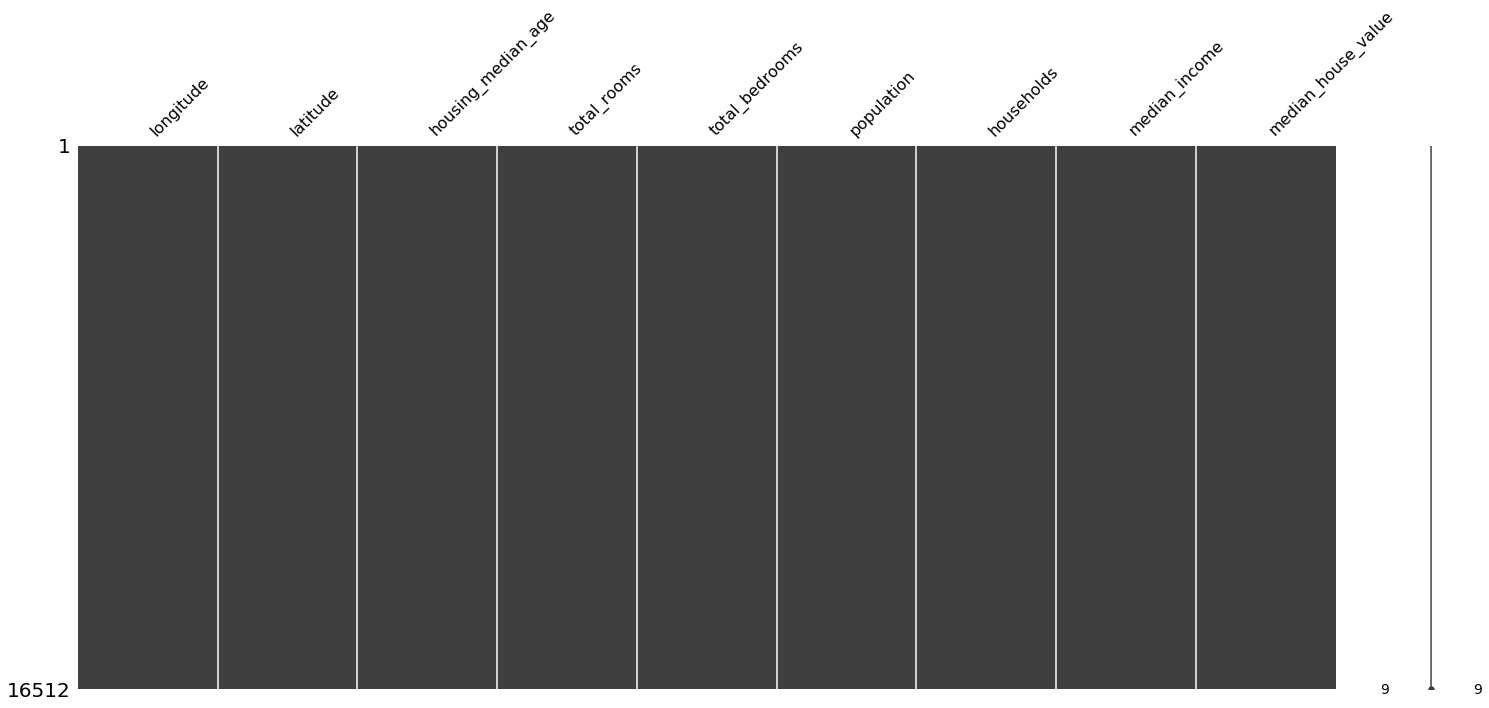

In [16]:
## Impute a median value to total_bedrooms variable
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median")

stImpute = strat_train.drop('ocean_proximity',axis=1)
imputer.fit(stImpute)
stImpute = pd.DataFrame( imputer.transform(stImpute), columns = stImpute.columns)
mn.matrix(stImpute)

In [17]:
## Create boolean dummies for categorical variable
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()
unoHot = encoder.fit_transform(strat_train.ocean_proximity)


In [18]:
## Create pipelines for above processes
## This process is new to me, but gtk.
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler

class dfSelect(BaseEstimator, TransformerMixin):
    def __init__(self, attributes):
        self.colSelect = attributes
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.colSelect].values


## The binarizer in sklearn was changed, so I have to create a feed through for the pipeline.
class binarizerPipelineFix(BaseEstimator, TransformerMixin):
    def __init__(self):
        return
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return LabelBinarizer().fit_transform(X)

## Select out numeric and categorical columns
housingPredictors = strat_train.drop("median_house_value",axis=1)
housingResponse = strat_train.median_house_value.copy()
numerics = [ i for i in list(housingPredictors) if housingPredictors[i].dtypes != "O" ]
cats = ["ocean_proximity"]

## Define pipeline for numerics
num_pipeline = Pipeline([
    ('selector', dfSelect(numerics)),
    ('imputer', Imputer(strategy="median")),
    ('std_scaler',StandardScaler())
])

## Define pipeline for categoricals
cat_pipeline = Pipeline([
    ('selector', dfSelect(cats)),
    ('label_binarizer', binarizerPipelineFix())
])

## Combine into one pipeline
full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline)
])

housingPrepped = full_pipeline.fit_transform(housingPredictors)
print(housingPrepped.shape)

(16512, 13)


In [19]:
## Spot check some models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

lin_reg = LinearRegression()
lin_reg.fit(housingPrepped, housingResponse)

yHat = lin_reg.predict(housingPrepped)

print("Linear Regression: ",np.sqrt(mean_squared_error(housingResponse, yHat)))

## At this point, they run a decision tree down to single leaves. I'm skipping to the cross validation.

tree_reg = DecisionTreeRegressor()

scores = cross_val_score(tree_reg, housingPrepped, housingResponse,
                         scoring = "neg_mean_squared_error", cv=10)
print("CV Tree: ", np.sqrt(-scores))

Linear Regression:  69050.9817824
CV Tree:  [ 68951.75436097  66660.6419979   72817.97063756  70281.88045786
  67517.94908303  76186.90100959  67562.46680797  70144.59601947
  70636.56423     69553.03038442]
